In [1]:
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt
import gymnasium as gym
from PIL import Image
import numpy as np
import imageio
import random
import time

In [2]:
#env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
desc=["FFFS", "FHFH", "HFFF", "GFHF"]
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode="rgb_array")
states = env.observation_space.n
actions = env.action_space.n

# Test the initial environment

In [3]:
state,info = env.reset()
state

3

In [4]:
action = env.action_space.sample()
action

2

In [5]:
new_state, reward, terminated, truncated, info = env.step(action)

In [6]:
env.render()

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]

In [7]:
print('--OBSERVATION SPACE--')
print(env.observation_space.n) # get number of states
print('----ACTION SPACE----')
print(env.action_space.n)      # get number of actions

--OBSERVATION SPACE--
16
----ACTION SPACE----
4


# Q Table Generation

In [8]:
Q = np.zeros((states, actions)) # creates a matrix with all zero values
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# Q Learning

[[0.7462933  0.47330288 0.78275779 0.58620693]
 [0.75144748 0.         0.8153727  0.78275779]
 [0.78275779 0.84934656 0.78275779 0.8153727 ]
 [0.8153727  0.         0.78275779 0.78275779]
 [0.         0.         0.         0.72431982]
 [0.         0.         0.         0.        ]
 [0.         0.884736   0.         0.8153727 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.96       0.884736   0.        ]
 [0.9216     0.         0.84934656 0.84934656]
 [0.884736   0.81365596 0.84896132 0.        ]
 [0.         0.         0.         0.        ]
 [1.         0.96       0.         0.9216    ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.84913625]]
Average reward: 0.8093333333333333


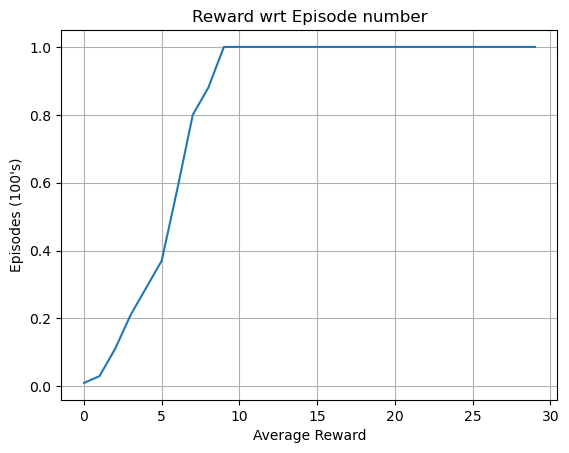

In [9]:
episodes = 3000       # how many times to run the environment from the beginning
max_steps = 200       # max number of steps allowed for each run of environment
learning_rate = 0.81  # learning rate (step size)
epsilon = 0.9         # start with a 0.9 chance of picking a random action
gamma = 0.96
render = False
rewards = []

for episode in range(episodes):
    state,info = env.reset() # reset environent to default state
    for _ in range(max_steps):
        if render:
            env.render()
            time.sleep(0.1)

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # get a random action
        else:
            # Exploitation: take the action with the highest state, action value
            action = np.argmax(Q[state, :])

        new_state, reward, terminated, truncated, info = env.step(action)

        Q[state, action] = Q[state, action] + learning_rate * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

        state = new_state

        if terminated:
            rewards.append(reward)
            epsilon -= 0.001
            break

print(Q)
print(f"Average reward: {sum(rewards) / len(rewards)}")

# Visualisation of learning process
def get_average(values):
    return sum(values)/len(values)

avg_rewards = []
for i in range(0,len(rewards),100):
    avg_rewards.append(get_average(rewards[i:i+100]))

plt.plot(avg_rewards)
plt.title('Reward wrt Episode number')
plt.xlabel('Average Reward')
plt.ylabel('Episodes (100\'s)')
plt.grid(True)
plt.show()

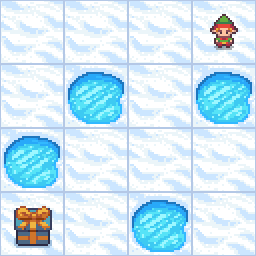

In [10]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []  
    terminated = False
    truncated = False
    state, info = env.reset(seed=random.randint(0, 500))
    img = env.render()
    if img is not None:  # Check if the rendered image is not None
        images.append(np.array(Image.fromarray(img)))  # Convert the rendered image to a numeric array
    while not terminated or truncated:
        # Take the action (index) that has the maximum expected future reward given the state
        action = np.argmax(Qtable[state][:])
        state, reward, terminated, truncated, info = env.step(action)  # We directly put next_state = state for recording logic
        img = env.render()
        if img is not None:  # Check if the rendered image is not None
            images.append(np.array(Image.fromarray(img)))  # Convert the rendered image to a numeric array
    
    if len(images) > 0:  # Check if there are valid images to save
        # Save the images as a GIF file
        imageio.mimsave(out_directory, images, fps=fps)

        # Display the GIF in the notebook
        display(IPImage(filename=out_directory))
    else:
        print("No valid images found to create the GIF.")

out_directory = "replay_video.gif"
record_video(env, Q, out_directory, fps=5)